## Generate Word Vectors
- [Neural Word Embedding as Implicit Matrix Factorization](http://u.cs.biu.ac.il/~nlp/wp-content/uploads/Neural-Word-Embeddings-as-Implicit-Matrix-Factorization-NIPS-2014.pdf)
- [text8 data](http://mattmahoney.net/dc/text8.zip)
- [wordsim353](http://www.cs.technion.ac.il/~gabr/resources/data/wordsim353/)
- [MEN Test collection](http://clic.cimec.unitn.it/~elia.bruni/MEN)

In [32]:
import numpy as np
import re
from scipy import sparse
import joblib
from collections import Counter
import matplotlib.pyplot as plt

In [33]:
%matplotlib inline

In [110]:
corpus = open("data/text8").read()
pat = re.compile("\w+")
%time words = pat.findall(corpus)
print len(words)

CPU times: user 3.45 s, sys: 452 ms, total: 3.91 s
Wall time: 3.91 s
17005207


In [111]:
%time total_word_counter = Counter(words)
WC_THR = 100
freq_words = set([w for w,c in total_word_counter.items() if c >= WC_THR])
print len(freq_words) *1. / len(total_word_counter), "% data are retained"
words = [w for w in words if w in freq_words]
print len(words)

CPU times: user 4.72 s, sys: 320 ms, total: 5.04 s
Wall time: 4.93 s
0.0465425008076 % data are retained
15471435


In [112]:
class Hasher(object):
    def __init__(self):
        self.N = 0
        self.data = {}
    def hash(self,item):
        if item not in self.data:
            self.data[item] = self.N
            self.N += 1
        return self.data[item]

In [113]:
def extract_wc_pairs(words, window = 3):
    wcpairs = []
    wordhasher = Hasher()
    contexthasher = Hasher()
    for i in xrange(window, len(words)-window):
        word, context = words[i], tuple(words[i-window:i]+words[i+1:i+window+1])
        hw, hc = wordhasher.hash(word), contexthasher.hash(context)
        wcpairs.append( (hw, hc) )
    return wordhasher, contexthasher, wcpairs

In [114]:
%time wordhasher, contexthasher, wcpairs = extract_wc_pairs(words, window=2)

CPU times: user 27.1 s, sys: 2.26 s, total: 29.4 s
Wall time: 29.3 s


In [115]:
%time whs, chs = zip(*wcpairs)
whs, chs = np.asarray(whs), np.asarray(chs)
Mshape = (wordhasher.N, contexthasher.N)

CPU times: user 34.9 s, sys: 1.93 s, total: 36.8 s
Wall time: 36.9 s


In [116]:
%time wcounter = Counter(whs)
%time ccounter = Counter(chs)
D = len(wcpairs)
k = 10.
%time data = np.array([D*1./wcounter[wh]/ccounter[ch]/k for wh,ch in wcpairs])

CPU times: user 4.92 s, sys: 99.1 ms, total: 5.01 s
Wall time: 4.88 s
CPU times: user 4.56 s, sys: 410 ms, total: 4.97 s
Wall time: 4.97 s
CPU times: user 26 s, sys: 805 ms, total: 26.8 s
Wall time: 26.7 s


In [117]:
%time M = sparse.coo_matrix((data, (whs, chs)), shape = Mshape, dtype=np.float32)
%time M = M.tocsr()
M.data = np.log(M.data)##
M[M<0.0] = 0.0
M.shape

CPU times: user 128 ms, sys: 85.6 ms, total: 214 ms
Wall time: 213 ms
CPU times: user 1.24 s, sys: 43.5 ms, total: 1.29 s
Wall time: 1.29 s


(11815, 13132213)

In [118]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, )

In [119]:
%time wvectors = svd.fit_transform(M)

CPU times: user 5min 56s, sys: 35 s, total: 6min 31s
Wall time: 6min 32s


## check word-context matrix & word vectors

In [122]:
print data.argmax()
print wcpairs[4771]
h2w[1211], h2c[4731]

4771
(1211, 4731)


('creation', ('then', 'begin', 'one', 's'))

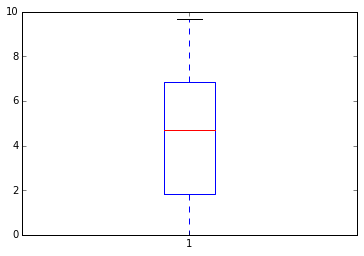

In [123]:
_ = plt.boxplot(M.data)

In [133]:
print wvectors.min(), wvectors.max()
print np.percentile(wvectors.ravel(), [5, 25, 50, 75, 95])

-447.070925306 883.888893924
[-0.013965013009280488, -0.00038266280651075247, 0.00010446357300787138, 0.0028947099433689655, 0.037908273507591878]


## save results

In [124]:
## inverse index
%time h2w = dict([(v,k) for k,v in wordhasher.data.items()])
%time h2c = dict([(v,k) for k,v in contexthasher.data.items()])

CPU times: user 64.2 ms, sys: 73.8 ms, total: 138 ms
Wall time: 137 ms
CPU times: user 38.9 s, sys: 3.81 s, total: 42.7 s
Wall time: 42.7 s


In [125]:


import h5py, cPickle

h5f = h5py.File("data/word_vectors.h5", "w")
%time h5f.create_dataset("data", data = wvectors)
h5f.close()

%time cPickle.dump(h2w, open("data/inverse_word_hash.pkl", "w"))
%time cPickle.dump(wordhasher.data, open("data/word_hash.pkl", "w"))
#%time cPickle.dump(h2c, open("data/inverse_context_hash.pkl", "w"))

CPU times: user 623 µs, sys: 6.81 ms, total: 7.44 ms
Wall time: 7.43 ms
CPU times: user 16.5 ms, sys: 2.97 ms, total: 19.4 ms
Wall time: 19.3 ms
CPU times: user 11.5 ms, sys: 1.49 ms, total: 13 ms
Wall time: 13.1 ms


## Evaluate Performance

In [126]:
import h5py, cPickle
h5f = h5py.File("data/word_vectors.h5", "r")
wvectors = h5f["data"][:]
h5f.close()

h2w = cPickle.load(open("data/inverse_word_hash.pkl"))
w2h = cPickle.load(open("data/word_hash.pkl"))

In [127]:
## use flann to find knn
import pyflann as pf
from scipy import stats

class NearestNeighbor(object):
    def __init__(self, k = 5, algorithm="kdtree", distance_type="euclidean"):
        pf.set_distance_type(distance_type)
        self.flann = pf.FLANN()
        self.k = k
        self.algorithm = algorithm#"autotuned"#algorithm
        self.iterations = 1000
    def train(self, X):
        self.X_ = X
    def nearest(self, X):
        min_index, dists = self.flann.nn(self.X_, X, self.k, 
                                         algorithm = self.algorithm, 
                                         iterations=self.iterations)
        return min_index, dists

In [128]:
nn=NearestNeighbor()
nn.train(wvectors)
%time neighbors, dists =nn.nearest(wvectors)

CPU times: user 483 ms, sys: 362 ms, total: 845 ms
Wall time: 62.9 ms


In [129]:
for row in neighbors[1000:1100, :]:
    print [h2w[r] for r in row]

['concerns', 'suggestions', 'besieged', 'dressed', 'surplus']
['variant', 'synthesis', 'mix', 'copy', 'wake']
['green', 'mysteries', 'calendar', 'basically', 'ethnic']
['authors', 'actors', 'refugees', 'peoples', 'europeans']
['mary', 'bits', 'vast', 'shape', 'abstract']
['proto', 'freud', 'inference', 'introductory', 'streams']
['precursor', 'dress', 'divergence', 'regulatory', 'eighteenth']
['opposing', 'basques', 'coastal', 'bend', 'malay']
['philosophies', 'edu', 'initiation', 'cliffs', 'orbitals']
['explains', 'sweeping', 'exchanges', 'qualification', 'intake']
['miss', 'epsilon', 'strain', 'restrict', 'zones']
['she', 'university', 'south', 'theory', 'around']
['wishes', 'rockets', 'superiority', 'heroic', 'extremes']
['make', 'henry', 'held', 'meters', 'eventually']
['privilege', 'veterans', 'im', 'employers', 'prefixes']
['whereby', 'aiming', 'observing', 'auxiliary', 'honors']
['proper', 'aftermath', 'rational', 'naval', 'expulsion']
['believes', 'asserts', 'leone', 'nacional'